# NER in RAG

In [1]:
%pip install pandas --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd


In [3]:
from os import environ
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

confluence_host = environ.get('CONFLUENCE_HOST')
confluence_token = environ.get('CONFLUENCE_TOKEN')
hf_token = environ.get('HF_TOKEN')
hf_write_token = environ.get('HF_WRITE_TOKEN')
gigachat_token = environ.get('GIGACHAT_TOKEN')
gigachat_pro_token = environ.get('GIGACHAT_PRO_TOKEN')
yandex_token = environ.get('YC_API_KEY')
openchat_host = environ.get('OPENCHAT_HOST')


## Датасет

### Загрузка датасета с Hugging Face

In [4]:
%pip install datasets --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
from datasets import load_dataset, DatasetDict

dataset_qda = load_dataset("nizamovtimur/wikiutmn-study-gigachat")
if isinstance(dataset_qda, DatasetDict):
    train_dataset_qda = dataset_qda['train'].to_pandas()
    test_dataset_qda = dataset_qda['test'].to_pandas()
else:
    train_dataset_qda = pd.DataFrame()
    test_dataset_qda = pd.DataFrame()
len(train_dataset_qda), len(test_dataset_qda)


(355, 67)

In [6]:
train_dataset_qda


,question,document,human_answer
0,Где продлять студак?,Для восстановления студенческого билета Вам не...,
1,Когда можно получить справку о стипендии?,"По вопросу получения справки о доходах, размер...",
2,Как перевестись на другое направление на заочке?,Заявления о переводе принимаются два раза в го...,
3,Как перевестись на другое направление?,Заявления о переводе принимаются два раза в го...,
4,Могу ли я в последний момент отказаться от сме...,"Прежде, чем выбрать элективы, рекомендуем почи...",
...,...,...,...
350,Как оформляются результаты промежуточной аттес...,"проведения промежуточной аттестации, за исключ...",
351,Кто несет ответственность за правильность офор...,"проведения промежуточной аттестации, за исключ...",
352,Что происходит с оценками после прохождения пр...,". 6. 10. Из ведомости, за исключением электрон...",
353,Кто несет ответственность за правильное внесен...,". 6. 10. Из ведомости, за исключением электрон...",


In [7]:
test_dataset_qda


,question,document,human_answer
0,Я потерял магнитную карту. К кому обратиться?,Для восстановления студенческого билета Вам не...,"Если Вы потеряли магнитную карту ( пропуск, пр..."
1,Даты подачи заявления для восстановления на очку,Заявления на восстановление в Университет по о...,Заявления на восстановление в Университет по о...
2,Что делать при потере проходки?,Для восстановления студенческого билета Вам не...,"Если Вы потеряли магнитную карту ( пропуск, пр..."
3,Я хожу в фитнес-клуб. Как заменить физкультуру?,Выбор спортивных секций по Физической культуре...,Для оформления посещения спортивного зала вмес...
4,Когда мне выдадут студенческий билет после пер...,"1. Подать заявление о переводе можно лично, об...",В течение пяти рабочих дней после поступления ...
...,...,...,...
62,как закрыть физкультуру?,Выбор спортивных секций по Физической культуре...,1 ) Посещать академические занятия ( 3 балла з...
63,когда можно поменять элективы?,"Прежде, чем выбрать элективы, рекомендуем почи...","Информация, о том, как поменять электив, отпра..."
64,как получить справку о месте учёбы?,Студенты очной формы обучения оформляют справк...,Студенты очной формы обучения оформляют справк...
65,Как можно получать баллы за физру?,Выбор спортивных секций по Физической культуре...,1 ) Посещать академические занятия ( 3 балла з...


In [29]:
documents_wikiutmn_gigachat = pd.concat([train_dataset_qda["document"], test_dataset_qda["document"]]).drop_duplicates().reset_index(drop=True)
questions_wikiutmn_gigachat = pd.concat([train_dataset_qda["question"], test_dataset_qda["question"]]).drop_duplicates().reset_index(drop=True)


In [35]:
print(len(documents_wikiutmn_gigachat))
print(len(questions_wikiutmn_gigachat))


42
413


### Генерация датасета с помощью Saiga по новым документам из боевой БД

In [17]:
# from typing import Optional
# from pgvector.sqlalchemy import Vector
# from sqlalchemy import Text, create_engine, select
# from sqlalchemy.orm import Mapped, Session, mapped_column

# Base = declarative_base()


# class Chunk(Base):
#     __tablename__ = "chunk"

#     id: Mapped[int] = mapped_column(primary_key=True)
#     confluence_url: Mapped[str] = mapped_column(Text(), index=True)
#     text: Mapped[str] = mapped_column(Text())
#     embedding: Mapped[Vector] = mapped_column(Vector(312))

#     time_created = Column(DateTime(timezone=True), server_default=func.now())
#     time_updated = Column(DateTime(timezone=True), onupdate=func.now())

# engine = create_engine(f"postgresql://{environ.get('POSTGRES_USER')}:{environ.get('POSTGRES_PASSWORD')}@{environ.get('POSTGRES_HOST')}/{environ.get('POSTGRES_DB')}", echo=False)

# with Session(engine) as session:
#     documents_from_db = [doc.text for doc in session.scalars(select(Chunk)).all()]
# len(documents_from_db)


70

In [26]:
from langchain.prompts import PromptTemplate

prompt_template = """
Действуй как студент. Составь 3 разнообразных вопроса к документу в тройных кавычках. Используй разговорный стиль речи и студенческую лексику, добавляй в вопрос название университета ТюмГУ, различные имена, названия подразделений, должности, контакты из документа. Отвечать на вопросы не нужно, напиши каждый вопрос с новой строки.

\"\"\"
{content}
\"\"\"

Вопросы:
"""

prompt = PromptTemplate.from_template(prompt_template)


In [ ]:
%pip install langchain_openai --quiet


In [27]:
from langchain_openai import ChatOpenAI

openchat = ChatOpenAI(
    # model="openchat_3.5",
    model="saiga_llama3_8b",
    openai_api_key="EMPTY",
    openai_api_base=openchat_host,
    temperature=0.6,
)

openchat_chain = prompt | openchat
openchat_chain.invoke({"content": documents_from_db[0]}).content


'1. ТюмГУ, когда я смогу оформить справку вызова на портале "Вместе", если я не сдал предыдущую сессию?\n2. Как мне узнать, что я не смогу получить справку вызова, если у меня есть академическая задолженность за предыдущую сессию?\n3. Как я смогу получить скан-копию справки вызова, если я оформил её самостоятельно на портале "Вместе"?'

In [ ]:
openchat_docs = []
for doc in documents_from_db:
    query = {"content": doc}
    chat_questions = openchat_chain.invoke(query).content.strip().split("\n")
    print(chat_questions)
    for q in chat_questions:
        q = q.strip()
        if len(q) < 5:
            continue
        openchat_docs.append({
            "question": q,
            "document": doc
        })
openchat_docs = pd.DataFrame(openchat_docs)
openchat_docs


In [ ]:
openchat_docs.to_csv("test_openchat_NE_docs.csv")


### Загрузка сгенерированного датасета

In [43]:
test_openchat_NE_docs = pd.read_csv("test_openchat_NE_docs.csv", index_col=0)
documents_wikiutmn_openchat = pd.concat([test_openchat_NE_docs["document"], test_openchat_NE_docs["document"]]).drop_duplicates().reset_index(drop=True)
questions_wikiutmn_openchat = pd.concat([test_openchat_NE_docs["question"], test_openchat_NE_docs["question"]]).drop_duplicates().reset_index(drop=True)
test_openchat_NE_docs


,question,document
0,1. Как я могу самостоятельно сформировать спра...,Сформировать справку - вызов Вы можете самосто...
1,2. В каком разделе и до какого срока я должен ...,Сформировать справку - вызов Вы можете самосто...
2,3. При каких условиях студентам заочной формы ...,Сформировать справку - вызов Вы можете самосто...
3,"1. Что мне сделать, чтобы получить справку для...",По вопросу получения справки для военкомата Ва...
4,2. Где и кто мне должен помочь с получением сп...,По вопросу получения справки для военкомата Ва...
...,...,...
205,2. Какие документы необходимо представить обуч...,"ФИО обучающегося, р езолюцией ответственного з..."
206,3. В документе о приоритете перехода обучающих...,"ФИО обучающегося, р езолюцией ответственного з..."
207,1. Какие условия необходимо удовлетворять обуч...,"необходимости, но не реже одного раза в семест..."
208,2. Какие приоритеты учитываются при распределе...,"необходимости, но не реже одного раза в семест..."


### Загрузка вопросов из БД

In [48]:
db = pd.read_csv('C:\\Users\\User\\Documents\\DB.txt', delimiter='\t')


## Выделение именованных сущностей

импорты библиотек и функция `get_NE_library(doc: str) -> str`

### SpaCy

In [37]:
%pip install spacy --quiet
import spacy
nlp = spacy.load('ru_core_news_lg')


Note: you may need to restart the kernel to use updated packages.


In [38]:
import matplotlib.pyplot as plt
from collections import Counter


При работе со SpaCy в датасете wikiutmn-study-gigachat:
Выявилось уникальных именованных сущностей в документах: 180
Не нашлось именованных сущностей в 1 документах
Максимальное кол-во именованных сущностей в документе: 28
Минимальное кол-во именованных сущностей в документе: 1
Среднее кол-во именованных сущностей в документе: 8.214285714285714
Наиболее часто встречаемые именованные сущности в документах: [('единый деканат', 18), ('unk', 18), ('университет', 15), ('фгаоу', 12), ('вместе', 11), ('семакова', 10), ('во " тюменский государственный университет "', 10), ('тюменский государственный университет', 8), ('тюмгу', 7), ('российский федерация', 7)]
Выявилось уникальных именованных сущностей в вопросах: 21
Не нашлось именованных сущностей в 363 вопросах
Максимальное кол-во именованных сущностей в вопросе: 2
Минимальное кол-во именованных сущностей в вопросе: 1
Среднее кол-во именованных сущностей в вопросе: 0.12832929782082325
Наиболее часто встречаемые именованные сущности в вопроса

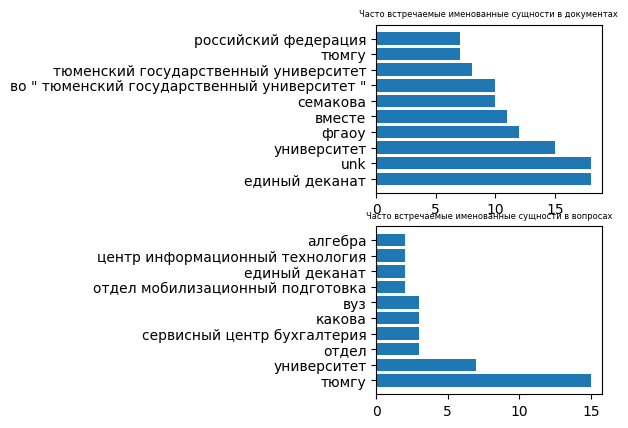

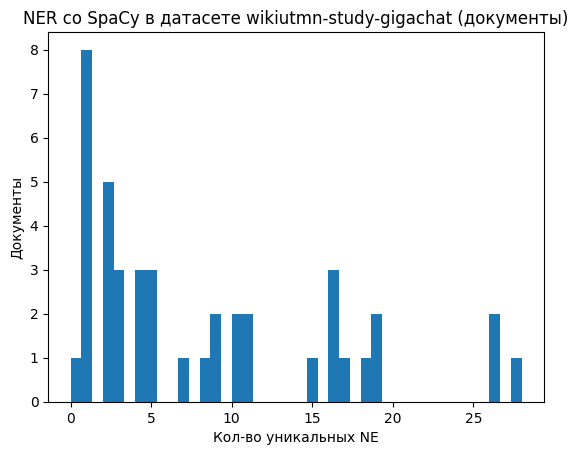

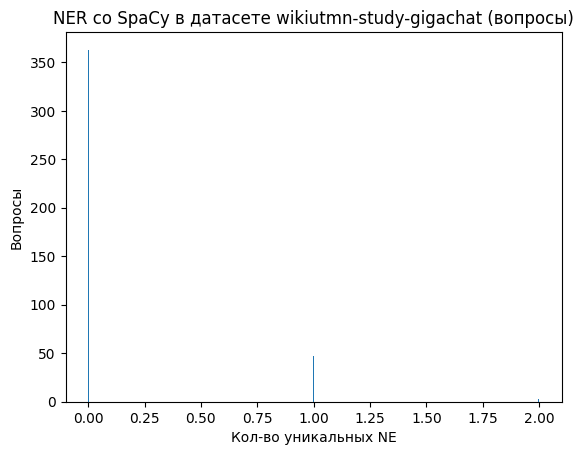


При работе со SpaCy в датасете test_openchat_NE_docs:
Выявилось уникальных именованных сущностей в документах: 347
Не нашлось именованных сущностей в 1 документах
Максимальное кол-во именованных сущностей в документе: 37
Минимальное кол-во именованных сущностей в документе: 1
Среднее кол-во именованных сущностей в документе: 10.885714285714286
Наиболее часто встречаемые именованные сущности в документах: [('unk', 45), ('единый деканат', 31), ('университет', 28), ('фгаоу', 26), ('во " тюменский государственный университет "', 23), ('тюменский государственный университет', 23), ('российский федерация', 20), ('оп', 13), ('вместе', 12), ('регламент', 10)]
Выявилось уникальных именованных сущностей в вопросах: 43
Не нашлось именованных сущностей в 90 вопросах
Максимальное кол-во именованных сущностей в вопросе: 3
Минимальное кол-во именованных сущностей в вопросе: 1
Среднее кол-во именованных сущностей в вопросе: 0.7142857142857143
Наиболее часто встречаемые именованные сущности в вопросах

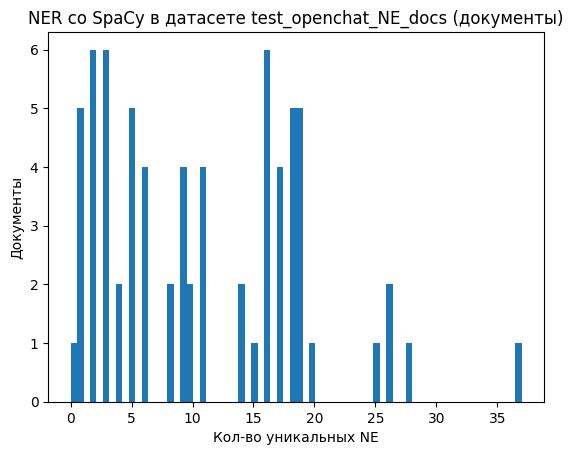

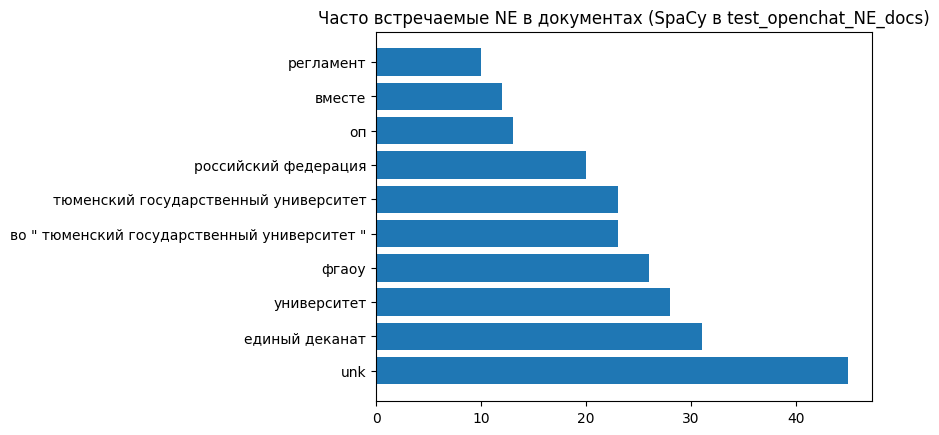

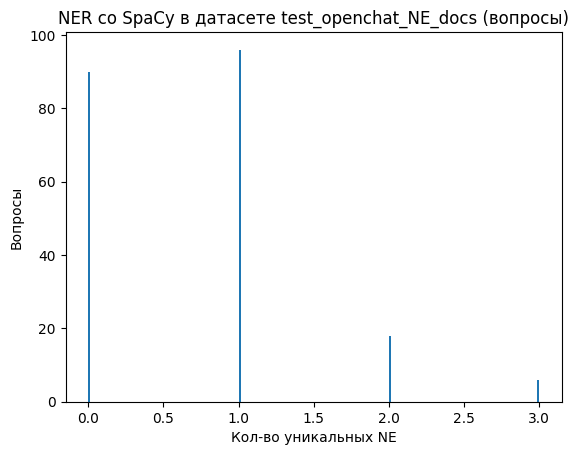

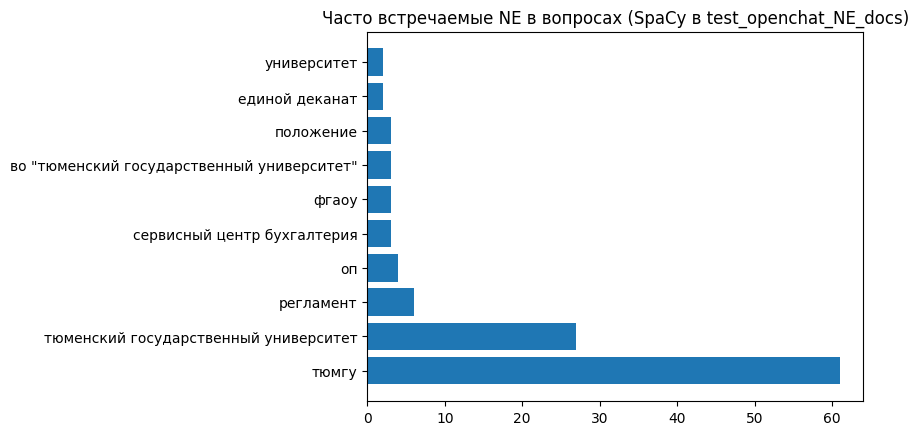


При работе со SpaCy в вопросах из БД:
Выявилось уникальных именованных сущностей: 65
Не нашлось именованных сущностей в 772 вопросах
Максимальное кол-во именованных сущностей в вопросе: 2
Минимальное кол-во именованных сущностей в вопросе: 1
Среднее кол-во именованных сущностей в вопросе: 0.18259935553168635
Наиболее часто встречаемые именованные сущности в вопросах: [('тюмгу', 37), ('вкр', 21), ('nan', 13), ('шкн', 12), ('тюмень', 4), ('фибоначчи', 4), ('романчук', 3), ('python', 3), ('тиу', 3), ('крым', 2)]


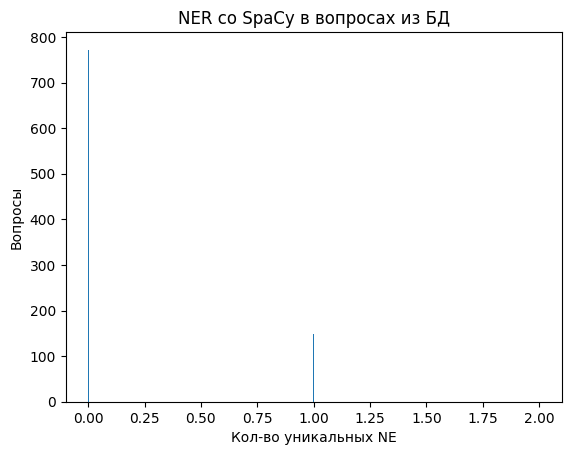

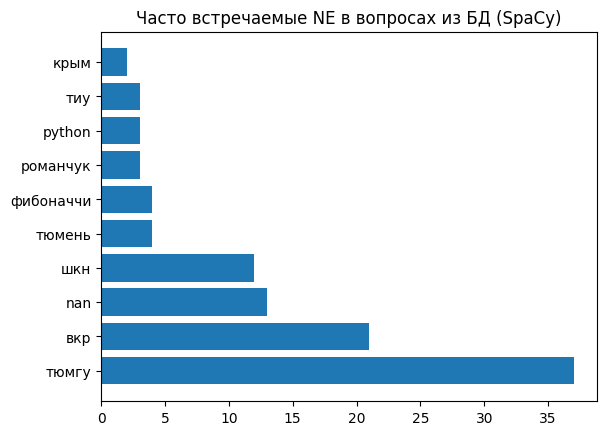

In [51]:
def find_spacy_ne(doc) -> list:
    return list(set([ent.lemma_ for ent in nlp(doc).ents]))
def analyze_spacy_ner(documents, questions):
    ne_docs = []
    ne_questions = []
    ne_docs_frequencies = []
    ne_questions_frequencies = []
    ne_docs_max = 0
    ne_docs_min = 100
    ne_docs_arg = 0
    docs_without_ne = 0
    ne_questions_max = 0
    ne_questions_min = 100
    ne_questions_arg = 0
    questions_without_ne = 0
    for document in documents:
        ents = find_spacy_ne(document)
        if len(ents):
            if len(ents) > ne_docs_max:
                ne_docs_max = len(ents)
            elif len(ents) < ne_docs_min and len(ents) > 0:
                ne_docs_min = len(ents)
            for i in ents:
                ne_docs.append(i)
        else:
            docs_without_ne += 1
        ne_docs_frequencies.append(len(ents))
    for question in questions:
        ents = find_spacy_ne(question)
        if len(ents):
            if len(ents) > ne_questions_max:
                ne_questions_max = len(ents)
            elif len(ents) < ne_questions_min and len(ents) > 0:
                ne_questions_min = len(ents)
            for i in ents:
                ne_questions.append(i)
        else:
            questions_without_ne += 1
        ne_questions_frequencies.append(len(ents))
    if (len(documents)): ne_docs_arg = len(ne_docs) / len(documents)
    if (len(questions)): ne_questions_arg = len(ne_questions) / len(questions)
    return ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies

ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies = analyze_spacy_ner(documents_wikiutmn_gigachat, questions_wikiutmn_gigachat)
print(f'При работе со SpaCy в датасете wikiutmn-study-gigachat:\nВыявилось уникальных именованных сущностей в документах: {len(set(ne_docs))}')
print(f'Не нашлось именованных сущностей в {docs_without_ne} документах')
print(f'Максимальное кол-во именованных сущностей в документе: {ne_docs_max}')
print(f'Минимальное кол-во именованных сущностей в документе: {ne_docs_min}')
print(f'Среднее кол-во именованных сущностей в документе: {ne_docs_arg}')
print(f'Наиболее часто встречаемые именованные сущности в документах: {Counter(ne_docs).most_common(10)}')
print(f'Выявилось уникальных именованных сущностей в вопросах: {len(set(ne_questions))}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')
print(f'Наиболее часто встречаемые именованные сущности в вопросах: {Counter(ne_questions).most_common(10)}')
plt.subplot(2, 2, 1)
plt.barh(*zip(*Counter(ne_docs).most_common(10)))
plt.title('Часто встречаемые именованные сущности в документах', fontdict={'fontsize': 6})
plt.subplot(2, 2, 3)
plt.barh(*zip(*Counter(ne_questions).most_common(10)))
plt.title('Часто встречаемые именованные сущности в вопросах', fontdict={'fontsize': 6})
plt.show()
n_bins = len(ne_docs_frequencies)
plt.hist(ne_docs_frequencies, bins=n_bins)
plt.title('NER со SpaCy в датасете wikiutmn-study-gigachat (документы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Документы')
plt.show()
n_bins = len(ne_questions_frequencies)
plt.hist(ne_questions_frequencies, bins=n_bins)
plt.title('NER со SpaCy в датасете wikiutmn-study-gigachat (вопросы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Вопросы')
plt.show()
ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies = analyze_spacy_ner(documents_wikiutmn_openchat, questions_wikiutmn_openchat)
print()
print(f'При работе со SpaCy в датасете test_openchat_NE_docs:\nВыявилось уникальных именованных сущностей в документах: {len(set(ne_docs))}')
print(f'Не нашлось именованных сущностей в {docs_without_ne} документах')
print(f'Максимальное кол-во именованных сущностей в документе: {ne_docs_max}')
print(f'Минимальное кол-во именованных сущностей в документе: {ne_docs_min}')
print(f'Среднее кол-во именованных сущностей в документе: {ne_docs_arg}')
print(f'Наиболее часто встречаемые именованные сущности в документах: {Counter(ne_docs).most_common(10)}')
print(f'Выявилось уникальных именованных сущностей в вопросах: {len(set(ne_questions))}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')
print(f'Наиболее часто встречаемые именованные сущности в вопросах: {Counter(ne_questions).most_common(10)}')
n_bins = len(ne_docs_frequencies)
plt.title('NER со SpaCy в датасете test_openchat_NE_docs (документы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Документы')
plt.hist(ne_docs_frequencies, bins=n_bins)
plt.show()
plt.barh(*zip(*Counter(ne_docs).most_common(10)))
plt.title('Часто встречаемые NE в документах (SpaCy в test_openchat_NE_docs)')
plt.show()
n_bins = len(ne_questions_frequencies)
plt.title('NER со SpaCy в датасете test_openchat_NE_docs (вопросы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Вопросы')
plt.hist(ne_questions_frequencies, bins=n_bins)
plt.show()
plt.barh(*zip(*Counter(ne_questions).most_common(10)))
plt.title('Часто встречаемые NE в вопросах (SpaCy в test_openchat_NE_docs)')
plt.show()
ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies = analyze_spacy_ner([], [str(question) for question in db['question']])
print()
print(f'При работе со SpaCy в вопросах из БД:\nВыявилось уникальных именованных сущностей: {len(set(ne_questions))}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')
print(f'Наиболее часто встречаемые именованные сущности в вопросах: {Counter(ne_questions).most_common(10)}')
n_bins = len(ne_questions_frequencies)
plt.title('NER со SpaCy в вопросах из БД')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Вопросы')
plt.hist(ne_questions_frequencies, bins=n_bins)
plt.show()
plt.barh(*zip(*Counter(ne_questions).most_common(10)))
plt.title('Часто встречаемые NE в вопросах из БД (SpaCy)')
plt.show()


In [31]:
db = pd.read_csv('C:\\Users\\User\\Documents\\DB.txt', delimiter='\t')


0      1137
1      1138
2      1142
3      1143
4      1144
       ... 
926    1297
927    1298
928    1299
929    1300
930    1301
Name: id, Length: 931, dtype: int64


### Natasha

In [4]:
%pip install natasha --quiet
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)


Note: you may need to restart the kernel to use updated packages.


При работе с natasha в датасете wikiutmn-study-gigachat:
Выявилось уникальных именованных сущностей в документах: 121
Не нашлось именованных сущностей в 3 документах
Максимальное кол-во именованных сущностей в документе: 21
Минимальное кол-во именованных сущностей в документе: 1
Среднее кол-во именованных сущностей в документе: 5.595238095238095
Наиболее часто встречаемые именованные сущности в документах: [('университет', 16), ('единый деканат', 12), ('вместе', 11), ('фгаоу во « тюменский государственный университет', 10), ('тюменский государственный университет', 10), ('семакова', 7), ('unk', 7), ('российская федерация', 7), ('тюмгу', 5), ('россия', 4)]
Выявилось уникальных именованных сущностей в вопросах: 15
Не нашлось именованных сущностей в 371 вопросах
Максимальное кол-во именованных сущностей в вопросе: 2
Минимальное кол-во именованных сущностей в вопросе: 1
Среднее кол-во именованных сущностей в вопросе: 0.1089588377723971
Наиболее часто встречаемые именованные сущности в вопр

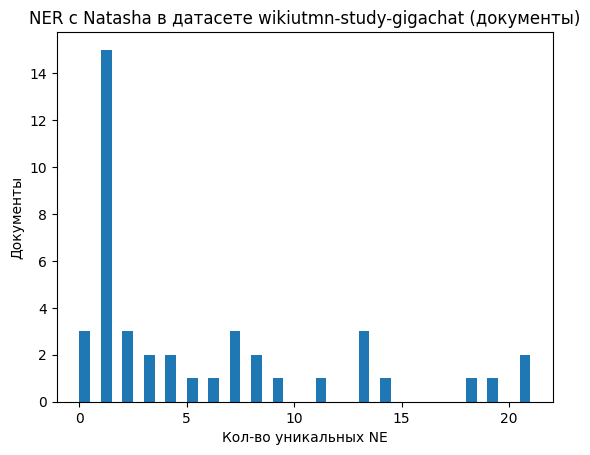

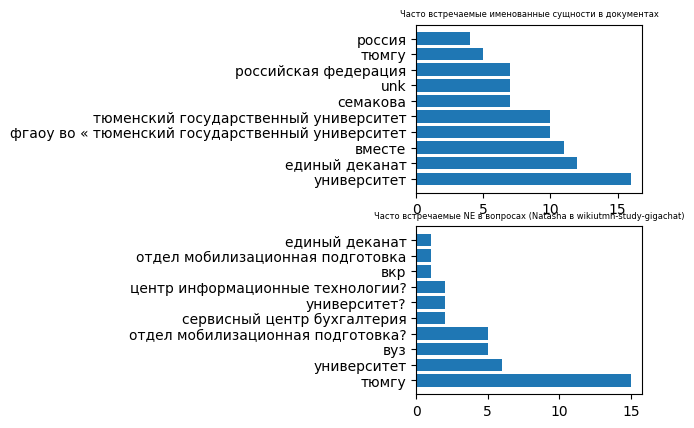

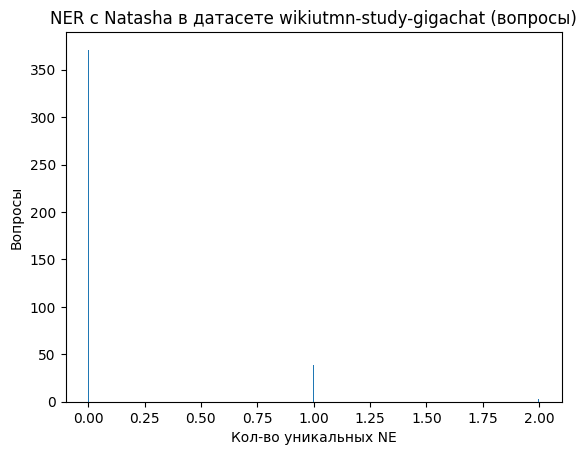


При работе с natasha в датасете test_openchat_NE_docs:
Выявилось уникальных именованных сущностей в документах: 228
Не нашлось именованных сущностей в 7 документах
Максимальное кол-во именованных сущностей в документе: 34
Минимальное кол-во именованных сущностей в документе: 1
Среднее кол-во именованных сущностей в документе: 7.585714285714285
Наиболее часто встречаемые именованные сущности в документах: [('университет', 30), ('тюменский государственный университет', 25), ('единый деканат', 24), ('фгаоу во « тюменский государственный университет', 23), ('unk', 23), ('российская федерация', 20), ('вместе', 12), ('оп', 11), ('тюмгу', 10), ('во', 9)]
Выявилось уникальных именованных сущностей в вопросах: 32
Не нашлось именованных сущностей в 98 вопросах
Максимальное кол-во именованных сущностей в вопросе: 3
Минимальное кол-во именованных сущностей в вопросе: 1
Среднее кол-во именованных сущностей в вопросе: 0.6
Наиболее часто встречаемые именованные сущности в вопросах: [('тюмгу', 61), (

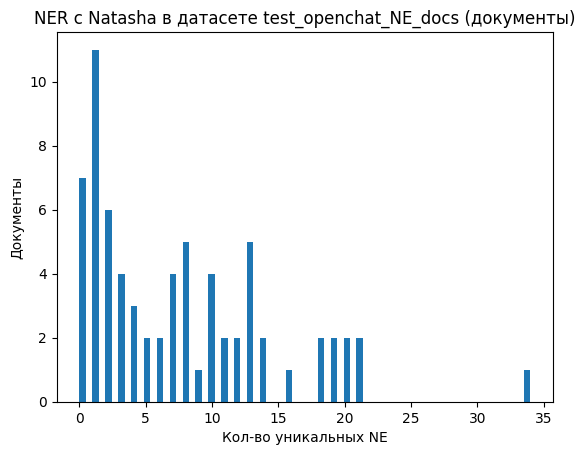

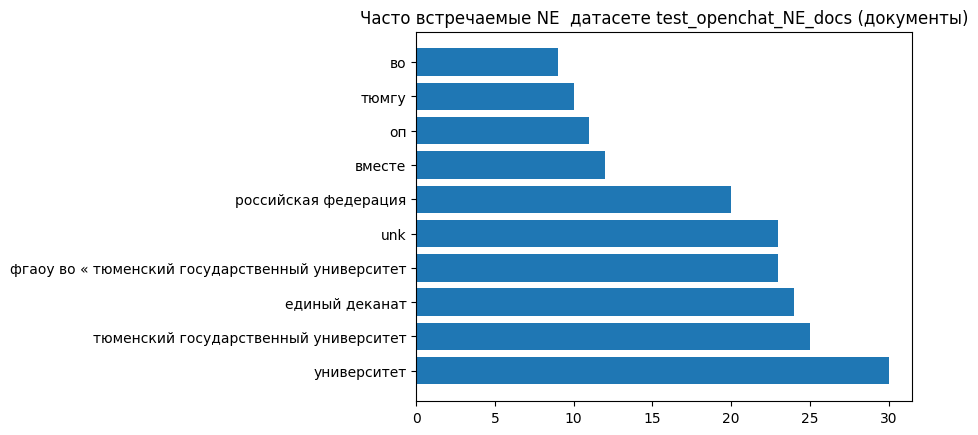

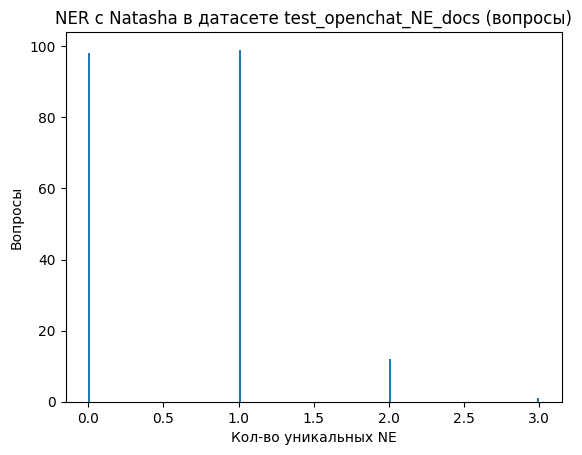

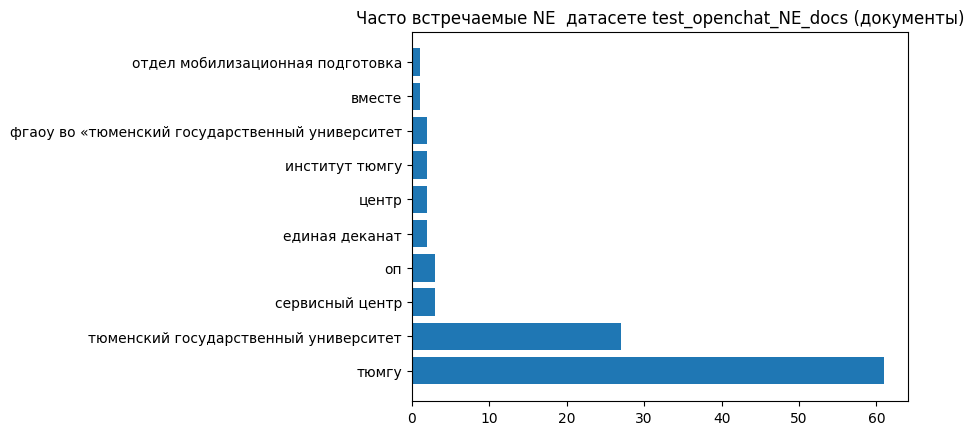


При работе с Natasha в вопросах из БД:
Выявилось уникальных именованных сущностей: 66
Не нашлось именованных сущностей в 809 вопросах
Максимальное кол-во именованных сущностей в вопросе: 2
Минимальное кол-во именованных сущностей в вопросе: 1
Среднее кол-во именованных сущностей в вопросе: 0.13533834586466165
Наиболее часто встречаемые именованные сущности в вопросах: [('тюмгу', 36), ('шкн', 7), ('вместе', 6), ('рассказавший', 4), ('вкр', 4), ('романчук', 3), ('тюмень', 3), ('тимур низамов', 2), ('романчук иван сергеевич', 2), ('тиу', 2)]


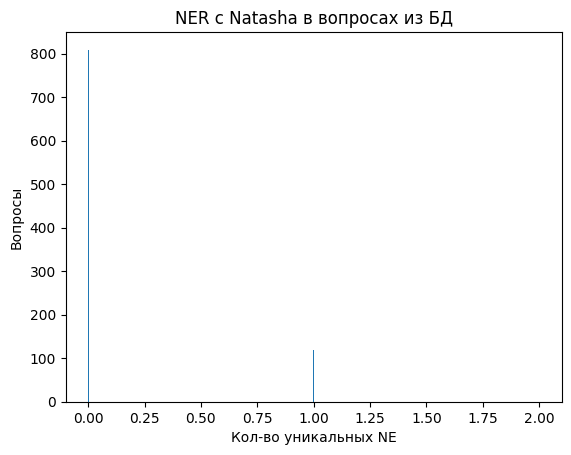

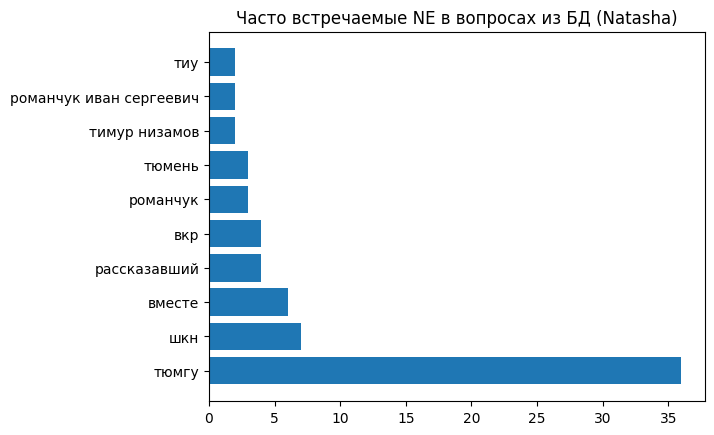

In [52]:
def find_natasha_ne(txt) -> list:
    doc = Doc(txt)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    ne = []
    for span in doc.spans:
        span.normalize(morph_vocab)
    for span in doc.spans:
        ne.append(span.normal.lower())
    return list(set(ne))
def analyze_natasha_ner(documents, questions):
    ne_docs = []
    ne_questions = []
    ne_docs_frequencies = []
    ne_questions_frequencies = []
    ne_docs_max = 0
    ne_docs_min = 100
    ne_docs_arg = 0
    docs_without_ne = 0
    ne_questions_max = 0
    ne_questions_min = 100
    ne_questions_arg = 0
    questions_without_ne = 0
    for document in documents:
        ents = find_natasha_ne(document)
        if len(ents):
            if len(ents) > ne_docs_max:
                ne_docs_max = len(ents)
            elif len(ents) < ne_docs_min and len(ents) > 0:
                ne_docs_min = len(ents)
            for i in ents:
                ne_docs.append(i)
        else:
            docs_without_ne += 1
        ne_docs_frequencies.append(len(ents))
    for question in questions:
        ents = find_natasha_ne(question)
        if len(ents):
            if len(ents) > ne_questions_max:
                ne_questions_max = len(ents)
            elif len(ents) < ne_questions_min and len(ents) > 0:
                ne_questions_min = len(ents)
            for i in ents:
                ne_questions.append(i)
        else:
            questions_without_ne += 1
        ne_questions_frequencies.append(len(ents))
    if len(documents): ne_docs_arg = len(ne_docs) / len(documents)
    if len(questions): ne_questions_arg = len(ne_questions) / len(questions)
    return ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies

ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies = analyze_natasha_ner(documents_wikiutmn_gigachat, questions_wikiutmn_gigachat)
print(f'При работе с natasha в датасете wikiutmn-study-gigachat:\nВыявилось уникальных именованных сущностей в документах: {len(set(ne_docs))}')
print(f'Не нашлось именованных сущностей в {docs_without_ne} документах')
print(f'Максимальное кол-во именованных сущностей в документе: {ne_docs_max}')
print(f'Минимальное кол-во именованных сущностей в документе: {ne_docs_min}')
print(f'Среднее кол-во именованных сущностей в документе: {ne_docs_arg}')
print(f'Наиболее часто встречаемые именованные сущности в документах: {Counter(ne_docs).most_common(10)}')
print(f'Выявилось уникальных именованных сущностей в вопросах: {len(set(ne_questions))}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')
print(f'Наиболее часто встречаемые именованные сущности в вопросах: {Counter(ne_questions).most_common(10)}')
n_bins = len(ne_docs_frequencies)
plt.hist(ne_docs_frequencies, bins=n_bins)
plt.title('NER с Natasha в датасете wikiutmn-study-gigachat (документы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Документы')
plt.show()
plt.subplot(2, 2, 1)
plt.barh(*zip(*Counter(ne_docs).most_common(10)))
plt.title('Часто встречаемые именованные сущности в документах', fontdict={'fontsize': 6})
plt.subplot(2, 2, 3)
plt.barh(*zip(*Counter(ne_questions).most_common(10)))
plt.title('Часто встречаемые NE в вопросах (Natasha в wikiutmn-study-gigachat)', fontdict={'fontsize': 6})
plt.show()
n_bins = len(ne_questions_frequencies)
plt.hist(ne_questions_frequencies, bins=n_bins)
plt.title('NER с Natasha в датасете wikiutmn-study-gigachat (вопросы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Вопросы')
plt.show()
ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies = analyze_natasha_ner(documents_wikiutmn_openchat, questions_wikiutmn_openchat)
print()
print(f'При работе с natasha в датасете test_openchat_NE_docs:\nВыявилось уникальных именованных сущностей в документах: {len(set(ne_docs))}')
print(f'Не нашлось именованных сущностей в {docs_without_ne} документах')
print(f'Максимальное кол-во именованных сущностей в документе: {ne_docs_max}')
print(f'Минимальное кол-во именованных сущностей в документе: {ne_docs_min}')
print(f'Среднее кол-во именованных сущностей в документе: {ne_docs_arg}')
print(f'Наиболее часто встречаемые именованные сущности в документах: {Counter(ne_docs).most_common(10)}')
print(f'Выявилось уникальных именованных сущностей в вопросах: {len(set(ne_questions))}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')
print(f'Наиболее часто встречаемые именованные сущности в вопросах: {Counter(ne_questions).most_common(10)}')
n_bins = len(ne_docs_frequencies)
plt.hist(ne_docs_frequencies, bins=n_bins)
plt.title('NER с Natasha в датасете test_openchat_NE_docs (документы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Документы')
plt.show()
plt.barh(*zip(*Counter(ne_docs).most_common(10)))
plt.title('Часто встречаемые NE  датасете test_openchat_NE_docs (документы)')
plt.show()
n_bins = len(ne_questions_frequencies)
plt.hist(ne_questions_frequencies, bins=n_bins)
plt.title('NER с Natasha в датасете test_openchat_NE_docs (вопросы)')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Вопросы')
plt.show()
plt.barh(*zip(*Counter(ne_questions).most_common(10)))
plt.title('Часто встречаемые NE  датасете test_openchat_NE_docs (документы)')
plt.show()
ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_docs_frequencies, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg, ne_questions_frequencies = analyze_natasha_ner([], [str(question) for question in db['question']])
print()
print(f'При работе с Natasha в вопросах из БД:\nВыявилось уникальных именованных сущностей: {len(set(ne_questions))}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')
print(f'Наиболее часто встречаемые именованные сущности в вопросах: {Counter(ne_questions).most_common(10)}')
n_bins = len(ne_questions_frequencies)
plt.title('NER с Natasha в вопросах из БД')
plt.xlabel('Кол-во уникальных NE')
plt.ylabel('Вопросы')
plt.hist(ne_questions_frequencies, bins=n_bins)
plt.show()
plt.barh(*zip(*Counter(ne_questions).most_common(10)))
plt.title('Часто встречаемые NE в вопросах из БД (Natasha)')
plt.show()


### DeepPavlov

In [3]:
import deeppavlov
from  nltk.tokenize import sent_tokenize


In [ ]:
ner_model = deeppavlov.build_model(deeppavlov.configs.ner.ner_rus_bert)


In [68]:
import pymorphy2

def find_deeppavlov_ne(txt) -> list:
    nes = []
    ne = []
    for i in sent_tokenize(txt):
        i = i.replace('_', '')
        try:
            tokens, tags = ner_model([i])
        except:
            continue
        for tok, tag in zip(tokens[0], tags[0]):
            if tag == 'O':
                if len(ne):
                    nes.append(' '.join([e for e in ne]))
                    ne.clear()
            else:
                if tag[0] == 'B':
                    if len(ne):
                        nes.append(' '.join([e for e in ne]))
                        ne.clear()
                ne.append(pymorphy2.MorphAnalyzer().parse(tok)[0].normal_form)
    return list(set(nes))

def analyze_deeppavlov_ner(documents, questions):
    ne_docs = []
    ne_questions = []
    ne_docs_max = 0
    ne_docs_min = 100
    ne_docs_arg = 0
    docs_without_ne = 0
    ne_questions_max = 0
    ne_questions_min = 100
    ne_questions_arg = 0
    questions_without_ne = 0
    for document in documents:
        ents = find_deeppavlov_ne(document)
        if len(ents):
            if len(ents) > ne_docs_max:
                ne_docs_max = len(ents)
            elif len(ents) < ne_docs_min and len(ents) > 0:
                ne_docs_min = len(ents)
            for i in ents:
                ne_docs.append(i)
        else:
            docs_without_ne += 1
    for question in questions:
        ents = find_deeppavlov_ne(question)
        if len(ents):
            if len(ents) > ne_questions_max:
                ne_questions_max = len(ents)
            elif len(ents) < ne_questions_min and len(ents) > 0:
                ne_questions_min = len(ents)
            for i in ents:
                ne_questions.append(i)
        else:
            questions_without_ne += 1
    ne_docs_arg = len(ne_docs) / len(documents)
    ne_questions_arg = len(ne_questions) / len(questions)
    return set(ne_docs), docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, set(ne_questions), questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg
ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg = analyze_deeppavlov_ner(documents_wikiutmn_gigachat, questions_wikiutmn_gigachat)
print(f'При работе с DeepPavlov в датасете wikiutmn-study-gigachat:\nВыявилось уникальных именованных сущностей в документах: {len(ne_docs)}')
print(f'Не нашлось именованных сущностей в {docs_without_ne} документах')
print(f'Максимальное кол-во именованных сущностей в документе: {ne_docs_max}')
print(f'Минимальное кол-во именованных сущностей в документе: {ne_docs_min}')
print(f'Среднее кол-во именованных сущностей в документе: {ne_docs_arg}')
print(f'Выявилось уникальных именованных сущностей в вопросах: {len(ne_questions)}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')
ne_docs, docs_without_ne, ne_docs_max, ne_docs_min, ne_docs_arg, ne_questions, questions_without_ne, ne_questions_max, ne_questions_min, ne_questions_arg = analyze_deeppavlov_ner(documents_wikiutmn_openchat, questions_wikiutmn_openchat)
print()
print(f'При работе с DeepPavlov в датасете test_openchat_NE_docs:\nВыявилось уникальных именованных сущностей в документах: {len(ne_docs)}')
print(f'Не нашлось именованных сущностей в {docs_without_ne} документах')
print(f'Максимальное кол-во именованных сущностей в документе: {ne_docs_max}')
print(f'Минимальное кол-во именованных сущностей в документе: {ne_docs_min}')
print(f'Среднее кол-во именованных сущностей в документе: {ne_docs_arg}')
print(f'Выявилось уникальных именованных сущностей в вопросах: {len(ne_questions)}')
print(f'Не нашлось именованных сущностей в {questions_without_ne} вопросах')
print(f'Максимальное кол-во именованных сущностей в вопросе: {ne_questions_max}')
print(f'Минимальное кол-во именованных сущностей в вопросе: {ne_questions_min}')
print(f'Среднее кол-во именованных сущностей в вопросе: {ne_questions_arg}')


При работе с DeepPavlov в датасете wikiutmn-study-gigachat:
Выявилось уникальных именованных сущностей в документах: 114
Не нашлось именованных сущностей в 3 документах
Максимальное кол-во именованных сущностей в документе: 23
Минимальное кол-во именованных сущностей в документе: 1
Среднее кол-во именованных сущностей в документе: 5.857142857142857
Выявилось уникальных именованных сущностей в вопросах: 12
Не нашлось именованных сущностей в 374 вопросах
Максимальное кол-во именованных сущностей в вопросе: 2
Минимальное кол-во именованных сущностей в вопросе: 1
Среднее кол-во именованных сущностей в вопросе: 0.09685230024213075

При работе с DeepPavlov в датасете test_openchat_NE_docs:
Выявилось уникальных именованных сущностей в документах: 200
Не нашлось именованных сущностей в 5 документах
Максимальное кол-во именованных сущностей в документе: 28
Минимальное кол-во именованных сущностей в документе: 1
Среднее кол-во именованных сущностей в документе: 7.7
Выявилось уникальных именованн

## Векторный индекс документов

### Структура БД

In [ ]:

!docker build ../db -t db


In [3]:
!docker run --name db --rm -p 5432:5432 --mount source=virtassist_db-data,target=/var/lib/postgresql/data --env-file ../.env -d db


87b907e57fd7f79b6c28f7822f3cbce48c19f51aa1ba15124975786c0df53906


In [27]:
from typing import Optional
from pgvector.sqlalchemy import Vector
from sqlalchemy import Text, create_engine, select, text
from sqlalchemy.orm import DeclarativeBase, Mapped, Session, mapped_column
engine = create_engine(f"postgresql://{environ.get('POSTGRES_USER')}:{environ.get('POSTGRES_PASSWORD')}@{environ.get('POSTGRES_HOST')}/{environ.get('POSTGRES_DB')}", echo=False)


In [28]:
class Base(DeclarativeBase):
    pass

class Chunk(Base):
    __tablename__ = "chunk"
    id: Mapped[int] = mapped_column(primary_key=True)
    text: Mapped[str] = mapped_column(Text())
    embedding: Mapped[Optional[Vector]] = mapped_column(Vector(312))
    named_entities_spacy: Mapped[Optional[str]] = mapped_column(Text())
    named_entities_natasha: Mapped[Optional[str]] = mapped_column(Text())
    named_entities_deeppavlov: Mapped[Optional[str]] = mapped_column(Text())


In [29]:
with Session(engine) as session:
    session.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    session.execute(text('DROP TABLE chunk'))
    session.commit()
Base.metadata.create_all(engine)


### Заполнение документами

In [74]:
# documents = pd.concat([train_dataset_qda["document"], test_dataset_qda["document"]]).drop_duplicates().reset_index(drop=True)
documents = test_openchat_NE_docs["document"].drop_duplicates().reset_index(drop=True)
len(documents)


70

In [1]:
import sentence_transformers
from sentence_transformers import SentenceTransformer
model_checkpoint = "nizamovtimur/rubert-tiny2-wikiutmn"
model = SentenceTransformer(model_checkpoint)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
with Session(engine) as session:
    for document in documents_wikiutmn_gigachat:
        doc = Chunk(
            text=document,
            embedding=model.encode(document),
            named_entities_spacy="\t".join(find_spacy_ne(document)),
            named_entities_natasha="\t".join(find_natasha_ne(document)),
            #named_entities_deeppavlov="\t".join(find_deeppavlov_ne(document))
        )
        session.add(doc)
    session.commit()


### Инициализация поиска

In [31]:
def answer_sbert(question):
    with Session(engine) as session:
        return session.scalars(select(Chunk)
                        .order_by(Chunk.embedding.cosine_distance(
                            model.encode(question)
                            )).limit(1)).first().text


In [42]:
from sqlalchemy import or_
def answer_ner_spacy(question):
    with Session(engine) as session:
        query = session.query(Chunk)
        query = query.filter(or_(*[Chunk.named_entities_spacy.contains(entity) for entity in find_spacy_ne(question)]))
        if len(query.all()):
            return query.order_by(Chunk.embedding.cosine_distance(
                            model.encode(question)
                            )).limit(1).first().text
        else:
            return session.scalars(select(Chunk)
                        .order_by(Chunk.embedding.cosine_distance(
                            model.encode(question)
                            )).limit(1)).first().text

answer_ner_spacy("Я студент в ШКН. Как перевестись из одной группы в другую в ТюмГУ")


'1. Подать заявление о переводе можно лично, обратившись в Единый деканат, ул. Семакова, 18, холл 3 этаж ( при себе необходимо иметь паспорт и СНИЛС ), либо предоставив полный пакет документов на почту ed @ utmn. ru. Заявления о переводе по очной и очно - заочной формам обучения принимаются 2 ( раза ) в год, как правило, в осеннем и весеннем семестрах в течение 2 ( двух ) недель начала семестра в соответствии с календарным учебным графиком. По заочной форме обучения не позднее чем за 2 ( два ) месяца до начала промежуточной аттестации / практики текущего семестра ( триместра, модуля ) по образовательной программе, на которую планируется перевод. Обучающийся представляет в Единый деканат ( ed @ utmn. ru ) справку о периоде обучения ( справку об обучении ) или сканированный вариант оригинала справки в PDF формате и письменное личное заявление или электронное личное заявление, отправленные с электронной почты. 2. Получить решение ТюмГУ - справку о переводе. ТюмГУ не позднее 10 ( десяти ) 

In [39]:
def answer_ner_natasha(question):
    with Session(engine) as session:
        query = session.query(Chunk)
        query = query.filter(or_(*[Chunk.named_entities_spacy.contains(entity) for entity in find_natasha_ne(question)]))
        if len(query.all()):
            return query.order_by(Chunk.embedding.cosine_distance(
                            model.encode(question)
                            )).limit(1).first().text
        else:
            return session.scalars(select(Chunk)
                        .order_by(Chunk.embedding.cosine_distance(
                            model.encode(question)
                            )).limit(1)).first().text
answer_ner_natasha("Я студент в ШКН. Как перевестись из одной группы в другую в ТюмГУ")


'1. Подать заявление о переводе можно лично, обратившись в Единый деканат, ул. Семакова, 18, холл 3 этаж ( при себе необходимо иметь паспорт и СНИЛС ), либо предоставив полный пакет документов на почту ed @ utmn. ru. Заявления о переводе по очной и очно - заочной формам обучения принимаются 2 ( раза ) в год, как правило, в осеннем и весеннем семестрах в течение 2 ( двух ) недель начала семестра в соответствии с календарным учебным графиком. По заочной форме обучения не позднее чем за 2 ( два ) месяца до начала промежуточной аттестации / практики текущего семестра ( триместра, модуля ) по образовательной программе, на которую планируется перевод. Обучающийся представляет в Единый деканат ( ed @ utmn. ru ) справку о периоде обучения ( справку об обучении ) или сканированный вариант оригинала справки в PDF формате и письменное личное заявление или электронное личное заявление, отправленные с электронной почты. 2. Получить решение ТюмГУ - справку о переводе. ТюмГУ не позднее 10 ( десяти ) 

### Выбор лучшего алгоритма (проверка на датасете wikiutmn-study-gigachat)

In [35]:
test_dataset_qda["sbert"] = test_dataset_qda["question"].apply(answer_sbert)
test_dataset_qda["spacy"] = test_dataset_qda["question"].apply(answer_ner_spacy)
test_dataset_qda["natasha"] = test_dataset_qda["question"].apply(answer_ner_natasha)
test_dataset_qda.head(5)


,question,document,human_answer,sbert,spacy,natasha
0,Я потерял магнитную карту. К кому обратиться?,Для восстановления студенческого билета Вам не...,"Если Вы потеряли магнитную карту ( пропуск, пр...",Для восстановления студенческого билета Вам не...,Для восстановления студенческого билета Вам не...,Для восстановления студенческого билета Вам не...
1,Даты подачи заявления для восстановления на очку,Заявления на восстановление в Университет по о...,Заявления на восстановление в Университет по о...,Пакет документов для восстановления вам необхо...,Пакет документов для восстановления вам необхо...,Пакет документов для восстановления вам необхо...
2,Что делать при потере проходки?,Для восстановления студенческого билета Вам не...,"Если Вы потеряли магнитную карту ( пропуск, пр...",Для восстановления студенческого билета Вам не...,Для восстановления студенческого билета Вам не...,Для восстановления студенческого билета Вам не...
3,Я хожу в фитнес-клуб. Как заменить физкультуру?,Выбор спортивных секций по Физической культуре...,Для оформления посещения спортивного зала вмес...,Выбор спортивных секций по Физической культуре...,Выбор спортивных секций по Физической культуре...,Выбор спортивных секций по Физической культуре...
4,Когда мне выдадут студенческий билет после пер...,"1. Подать заявление о переводе можно лично, об...",В течение пяти рабочих дней после поступления ...,"1. Подать заявление о переводе можно лично, об...","1. Подать заявление о переводе можно лично, об...","1. Подать заявление о переводе можно лично, об..."


### Accuracy

In [36]:
for column in test_dataset_qda.columns[2:]:
    print(column, sum(test_dataset_qda[column].apply(lambda x: "" if x is None else x) == test_dataset_qda.document) / len(test_dataset_qda.document))


human_answer 0.31343283582089554
sbert 0.7164179104477612
spacy 0.6865671641791045
natasha 0.6865671641791045


### ROUGE-L

In [37]:
from rouge import Rouge
rouge = Rouge()

for column in test_dataset_qda.columns[2:]:
    print(column, rouge.get_scores(test_dataset_qda[column].apply(lambda x: "-" if x is None else x), test_dataset_qda["document"], avg=True)['rouge-l'])


human_answer {'r': 0.6170558241367031, 'p': 0.9958196833933283, 'f': 0.7133136761037521}
sbert {'r': 0.7860354693644203, 'p': 0.7710458235173536, 'f': 0.76751259029231}
spacy {'r': 0.7751072338297648, 'p': 0.7498739222087594, 'f': 0.7497902599229568}
natasha {'r': 0.7751072338297648, 'p': 0.7498739222087594, 'f': 0.7497902599229568}


### Выбор лучшего алгоритма (проверка на датасете test_openchat_NE_docs)

In [49]:
test_openchat_NE_docs["sbert"] = test_openchat_NE_docs["question"].apply(answer_sbert)
test_openchat_NE_docs["spacy"] = test_openchat_NE_docs["question"].apply(answer_ner_spacy)
test_openchat_NE_docs["natasha"] = test_openchat_NE_docs["question"].apply(answer_ner_natasha)
test_openchat_NE_docs.head(5)


C:\Users\User\AppData\Local\Temp\ipykernel_2192\2733464281.py:6: SADeprecationWarning: Invoking or_() without arguments is deprecated, and will be disallowed in a future release.   For an empty or_() construct, use 'or_(false(), *args)' or 'or_(False, *args)'.
  query = query.filter(or_(*[Chunk.named_entities_spacy.contains(entity) for entity in find_natasha_ne(question)]))


,question,document,sbert,spacy,natasha
0,1. Как я могу самостоятельно сформировать спра...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...
1,2. В каком разделе и до какого срока я должен ...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...
2,3. При каких условиях студентам заочной формы ...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...,Сформировать справку - вызов Вы можете самосто...
3,"1. Что мне сделать, чтобы получить справку для...",По вопросу получения справки для военкомата Ва...,По вопросу получения справки для военкомата Ва...,"Если Вы являетесь студентом ТюмГУ, то для полу...","Если Вы являетесь студентом ТюмГУ, то для полу..."
4,2. Где и кто мне должен помочь с получением сп...,По вопросу получения справки для военкомата Ва...,По вопросу получения справки для военкомата Ва...,По вопросу получения справки для военкомата Ва...,По вопросу получения справки для военкомата Ва...


#### Accuracy

In [52]:
for column in test_openchat_NE_docs.columns[2:]:
    print(column, sum(test_openchat_NE_docs[column].apply(lambda x: "" if x is None else x) == test_openchat_NE_docs.document) / len(test_openchat_NE_docs.document))


sbert 0.44285714285714284
spacy 0.3904761904761905
natasha 0.38095238095238093


#### ROUGE-L

In [53]:
%pip install rouge --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
from rouge import Rouge
rouge = Rouge()

for column in test_openchat_NE_docs.columns[2:]:
    print(column, rouge.get_scores(test_openchat_NE_docs[column].apply(lambda x: "-" if x is None else x), test_openchat_NE_docs["document"], avg=True)['rouge-l'])


sbert {'r': 0.5815014188877036, 'p': 0.6088098837901458, 'f': 0.568727083330976}
spacy {'r': 0.5484565126260628, 'p': 0.5618241579119402, 'f': 0.5274733103035136}
natasha {'r': 0.5368371472140543, 'p': 0.5531557274527733, 'f': 0.5173997343012992}
